<img src=" " height="300" width="300"> 

# <center> R для тервера и матстата. <br>  <br> 6.1 Проверка гипотез. Часть первая. </center>

Данный ноутбук является конспектом по курсу «R для теории вероятностей и математической статистики» (РАНХиГС, 2017-2018). Автор ноутбука [вот этот парень по имени Филипп.](https://vk.com/ppilif) Если у вас для него есть деньги, слава или женщины, он от этого всего не откажется. Ноутбук распространяется на условиях лицензии [Creative Commons Attribution-Share Alike 4.0.](https://creativecommons.org/licenses/by-sa/4.0/) При использовании обязательно упоминание автора курса и аффилиации. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу курса.](https://fulyankin.github.io/R_probability/) На ней можно найти другие материалы. Фрагменты кода, включенные в этот notebook, публикуются как [общественное достояние.](https://creativecommons.org/publicdomain/zero/1.0/)

---------

Ура! Мы добрались до самого главного. До проверки гипотез. Аналитики в разных компаниях проверяют их на ежедневной основе. Давайте попробуем разобраться зачем. Для начала немного кода для красивых картинок в ggplot2. Как обычно, вы не обязаны понимать этот код. Он тут нужен для красоты. 

In [123]:
library('ggplot2')

# В этом блоке написаны несколько функций, которые рисуют красивые картинки для проверки гипотез.
# Можно не обращать на них внимание :) 

# Область, которую надо будет закрасить на графике 
limitRange <- function(fun, min, max) {
    function(x) {
        y <- fun(x)
        y[x < min  |  x > max] <- NA
        return(y)
    }
}

z_stat_picture <- function(z_stat, alpha =0.05, alternative = 'two-sided'){
    # Опции для размеров графика
    options(repr.plot.width=6, repr.plot.height=3)
    
    # Какие области надо закрасить (зависит от алтиернативы)
    if(alternative == 'two-sided'){
        z_crit <- qnorm(1-(alpha/2))
        dlimit_left  <- limitRange(dnorm, -Inf, -z_crit) 
        dlimit_right <- limitRange(dnorm, z_crit, Inf) 
        }
    if(alternative == 'less'){
        z_crit <- qnorm(alpha)
        dlimit_left  <- limitRange(dnorm, -Inf, z_crit)
        dlimit_right <- limitRange(dnorm, Inf, Inf)        
    }
    if(alternative == 'greater'){
        z_crit <- qnorm(1 - alpha)
        dlimit_left  <- limitRange(dnorm, -Inf, -Inf)
        dlimit_right <- limitRange(dnorm, z_crit, Inf)
        }        
      
    # Основная картинка
    p <- ggplot(data.frame(x=c(-4,4)), aes(x = x))+
       stat_function(fun=dnorm) +  # вся функция 
       stat_function(fun=dlimit_left, geom="area",  fill="blue", alpha=0.2) +
       stat_function(fun=dlimit_right, geom="area", fill="blue", alpha=0.2) +
       geom_point(aes(x=z_stat,y=0), color="red", size=2) +
       geom_vline(xintercept = z_stat, size=0.3, linetype="dashed", color="red") +
       annotate("text", label=round(z_stat,2), x= z_stat, y=0.2, parse=T, size=4, color="darkred")
    
    # Рисуем критические точки 
    if(alternative == 'two-sided'){
       p <- p + annotate("text", label=round(z_crit,2), x=z_crit+0.1, y=-0.02, parse=T, size=4) + 
                annotate("text", label=round(-z_crit,2), x=-z_crit-0.1, y=-0.02, parse=T, size=4)
        }
    if(alternative == 'less'){
       p <- p + annotate("text", label=round(z_crit,2), x=z_crit-0.1, y=-0.02, parse=T, size=4)
        }
    if(alternative == 'greater'){
       p <- p + annotate("text", label=round(z_crit,2), x=z_crit+0.1, y=-0.02, parse=T, size=4)
        }      
    
    # Немного заключительных настроек, связанных с темой и вывод на экран 
    p <- p + theme(
             axis.text.x = element_blank(),
             axis.text.y = element_blank(),
             axis.ticks = element_blank(),
             axis.title.x = element_blank(),
             axis.title.y = element_blank()
            )
    
    return(p)
}

In [124]:
# Точно такой же рисунок для t-статистики
t_stat_picture <- function(t_stat, n, alpha =0.05, alternative = 'two-sided'){
    # Опции для размеров графика
    options(repr.plot.width=6, repr.plot.height=3)
    
    # Какие области надо закрасить (зависит от алтиернативы)
    if(alternative == 'two-sided'){
        t_crit <- qt(1-(alpha/2),df=n)
        dlimit_left  <- limitRange(function(x) dt(x, df=n), -Inf, -t_crit) 
        dlimit_right <- limitRange(function(x) dt(x, df=n), t_crit, Inf) 
        }
    if(alternative == 'less'){
        t_crit <- qt(alpha,df=n)
        dlimit_left  <- limitRange(function(x) dt(x, df=n), -Inf, t_crit)
        dlimit_right <- limitRange(function(x) dt(x, df=n), Inf, Inf)        
    }
    if(alternative == 'greater'){
        t_crit <- qt(1 - alpha,df=n)
        dlimit_left  <- limitRange(function(x) dt(x, df=n), -Inf, -Inf)
        dlimit_right <- limitRange(function(x) dt(x, df=n), t_crit, Inf)
        }        
      
    # Основная картинка
    p <- ggplot(data.frame(x=c(-4, 4)), aes(x = x))+
       stat_function(fun=dt, args = list(df=n)) +  # вся функция 
       stat_function(fun=dlimit_left, args = list(df=n), geom="area",  fill="blue", alpha=0.2) +
       stat_function(fun=dlimit_right, geom="area", fill="blue", alpha=0.2) +
       geom_point(aes(x=t_stat,y=0), color="red", size=2) +
       geom_vline(xintercept = t_stat, size=0.3, linetype="dashed", color="red") +
       annotate("text", label=round(t_stat,2), x= t_stat, y=0.2, parse=T, size=4, color="darkred")
    
    # Рисуем критические точки 
    if(alternative == 'two-sided'){
       p <- p + annotate("text", label=round(t_crit,2), x=t_crit+0.1, y=-0.02, parse=T, size=4) + 
                annotate("text", label=round(-t_crit,2), x=-t_crit-0.1, y=-0.02, parse=T, size=4)
        }
    if(alternative == 'less'){
       p <- p + annotate("text", label=round(t_crit,2), x=t_crit-0.1, y=-0.02, parse=T, size=4)
        }
    if(alternative == 'greater'){
       p <- p + annotate("text", label=round(t_crit,2), x=t_crit+0.1, y=-0.02, parse=T, size=4)
        }      
    
    # Немного заключительных настроек, связанных с темой и вывод на экран 
    p <- p + theme(
             axis.text.x = element_blank(),
             axis.text.y = element_blank(),
             axis.ticks = element_blank(),
             axis.title.x = element_blank(),
             axis.title.y = element_blank()
            )
    
    return(p)
}

# 1. Что такое гипотезы и зачем их проверять 

На самом деле мы можем сказать, что статистическая гипотеза это абсолютно любое утверждение, которое возникает в нашей голове, если его можно проверить с помощью данных. Например: 

* В Австралии женщин дискриминируют на рынке труда! Они получают в среднем денег меньше, чем мужчины. 
* В Питере люди любят кофе больше, чем в москве! Доля людей, любящих кофе в Питере гораздо больше, чем в Москве.
* Посетители постоянно покупают в паре пиво и подгузники. Мы могли бы использовать это, чтобы увеличить прибыль. 
* Пауль - настоящий прорицатель! Его предсказания всегда сбываются!!! 
* Доходности по акциям Яндекса имеют нормальное распределение. Мы можем использовать его, чтобы понять насколько вложения в них рискованны. 

Каждое из этих утверждений может быть проверено на данных. Сразу же стоит сказать важную вещь. __Гипотезы нельзя принмать!__ Если кто-то при вас сказал, что он принял гипотезу, нужно срочно ударить этого человека по губам. Предположим, что мы собрали данные, связанные с предсказаниями Пауля. Предположим, что данные не противоречат тому, что Пауль действительно видит будущее. Означает ли это, что Пауль - провидец? Вовсе нет, это означает, что текущие данные не противоречат этому. Возможно, если мы ещё понаблюдаем за предсказаниями Пауля, гипотеза о том, что он провидец, отвергнется. Если данные не противоречат нашему утверждению, это не является доказательством его верности. В матемтике да это всегда да, а нет это хотя бы один раз нет. Возможно, наше нет ещё не наступило. Именно поэтому гипотезы нельзя принимать, но можно не отвергать. __Ещё раз, ещё раз__ если кто-то говорит, что принял гипотезу, нужно уведомить его, что он её вовсе не принял, а не отверг. Не стесняйтесь делать это. 

Давайте посмотрим на конкретный пример. Джеймс Бонд утверждает, что он предпочитает пить мартини взболтанным, но не смешанным. Чтобы проверить это на практике, можно предложить ему пройти так называемый blind test, или слепое тестирование. Можно было бы завязать ему глаза, несколько раз предложить на выбор взболтанный и смешанный мартини, а после этого спросить какой напиток он предпочитает В данном случае если бы Джеймс Бонд выбрал взболтанный напиток, это считалось бы успехом, потому что его выбор соответствовал бы его утверждению. В противном случае считалось бы, что произошла неудача. 

Сформулируем нашу первую гипотезу! Обычно, гипотезу, выдвинутую для проверки называют __нулевой или основной.__ 

$$H_0: \quad \text{ Джеймс Бонд не различает два вида напитков и выбирает наугад.}$$ 

На языке математики это утверждение можно сформулировать с посощью Бернулиевской случайной величины. Как мы помним, у неё есть единтвенный параметр $p$, вероятность успеха. Если Джеймс Бонд не различает два напитка и берёт их наугад, то $p = 0.5$. Если нет, то он должен выбирать правильный напиток чаще неправильного и $p > 0.5$. Нулевая гипотеза рвоно так и будет выглядеть:

$$
H_0: \quad p = \frac{1}{2}
$$

Эту гипотезу мы должны проверять против какой-то альтернативы. Альтернатива может быть разной. С одной стороны, мы можем рассмотреть двустороннюю альтернативу, состояшую в том, что агент Бонд различает два напитка между собой

$$
H_1: \quad p \ne \frac{1}{2}.
$$

С другой, мы могли бы рассмотреть одну из односторонних альтернатив. Например, что Бонд предпочитает именно вболтанный Мартини

$$
H_1: \quad p > \frac{1}{2}.
$$

Эксперимент с завязанными глазами нужно провести $n$ раз. В итоге у нас в руках окажется выборка, по которой мы сможем найти $\hat p$. Предположим, что на основе 10 испытаний мы получили, что $\hat p = \frac{6}{10}$. Означает ли это, что Бонд отвечает за свои слова? 

Возникает соблазн сказать, что да, так как число получилось больше $\frac{1}{2}$, и это ошибочный соблазн. Давайте вспомним немаловажный факт: наша оценка $\hat p$ это функция от выборки. При других наблюдениях мы могли бы получить другую оценку. Хочется понять насколько сильно эта оценка отличается от нашей.

Секундочку! Мы же уже умеем отвечать на этот вопрос. За точность оценки отвечает доверительный интервал. Мы помним, что 

$$\hat p \sim N \left(p, \frac{p(1-p)}{n} \right).$$

Исходя отсюда мы можем построить доверительный интервал и всё станет понятнее. Для нашей ситуации получим: 

In [125]:
p_hat = 0.6
n = 10

sd_p = sqrt(p_hat*(1-p_hat)/n)
p_left  = p_hat - qnorm(1-0.05/2)*sd_p
p_right = p_hat + qnorm(1-0.05/2)*sd_p
cat('Параметр p с вероятностью 95% лежит между',p_left, 'и', p_right, '\n')
cat('Ширина интервала:', p_right - p_left)

Параметр p с вероятностью 95% лежит между 0.2963637 и 0.9036363 
Ширина интервала: 0.6072726

Диапозон вышел довольно широким. Более того, в него попадает $0.5$. Получается, что Джеймс вполне может врать. 

Итак, для разных выборок, наша оценка способностей Бонда различать напитки, может оказаться разной. Если расстояние от оценки до предполагаемого значения, $\hat p - 0.5$, окажется довольно маленьким, судя по всему, Бонд не может распознавать напитки. Выбор между ними происходит абсолютно случайно.

Осталось только формализовать, когда расстояние от нашей оценки $\hat p$ до $0.5$ маленькое. Так как наша оценка - случайная величина, то и расстояние до $0.5$ будет слачейной величиной. Мы знаем, что 

$$
\hat p \sim N \left(p, \frac{p(1-p)}{n} \right).
$$

Если нулевая гипотеза верна, тогда истиное значение $p$ будет равно $0.5$ и 

$$
\hat p \sim N \left(0.5, \frac{0.5(1-0.5)}{10} \right).
$$

Расстояние до $0.5$ будет распределено с нулевым математическим ожиданием 

$$
\hat p - 0.5 \sim N \left(0, \frac{0.5(1-0.5)}{10} \right).
$$

Поделим всё это для удобства на стандартное отклонение и получим __статистику__ для проверки гипотезы

$$
\frac{\hat p - 0.5}{\sqrt{\frac{0.5(1-0.5)}{10}}} \sim N (0,1).
$$

На основе этой статистики мы можем судить о том, насколько вероятно было получить по выборке $\hat p$, если в реальности природа задумала $0.5$. При справедливости альтернативы более вероятны большие значения статистики. Дело осталось за малым - выбрать порог, с которого начинаются такие значения. 

При проверке гипотезы мы можем ошибиться и отвергунть $H_0$, когда она была верна. Хотелось бы, чтобы количество таких ошибок было заранее зафиксировано. Будем перед проверкой гипотезы объявлять желаемое число таких ошибок - уровень значимости, $\alpha$. 

Напомню, что если мы упаковываем $100$ парашютов на $5\%$ уровне значимости, значит $5$ человек умрут. Если мы зафиксировали для запаковки такой уровень значимости, значит мы готовы смириться с этими смертями. 

Если альтернатива двусторонняя, то не хотелось бы получить очень маленькие значения статистики или, наоборот, очень большие её значения. Будем считать, что если наблюдаемое значение статистики, $z$ попало в $1-\alpha$ процентный доверительный интервал, то всё окей и данные не противоречат нулевой гипотизе. 

Посмотрим на то как это выглядит на картинке. Мы зафиксировали $5\%$ уровень значимости. После посчитали наблюдаемое значение статистики. Оно оказалось равно $0.65$. Критические значения статистики равны $\pm 1.96$. Мы можем найти их исходя из нормального распределения, также как мы делали это для доверительных интервалов. За ними начинается критическая область. Если наблюдаемое значение попадает в эту область, то мы считаем расстояние между $\hat p$ и $0.5$ слишком большим. 

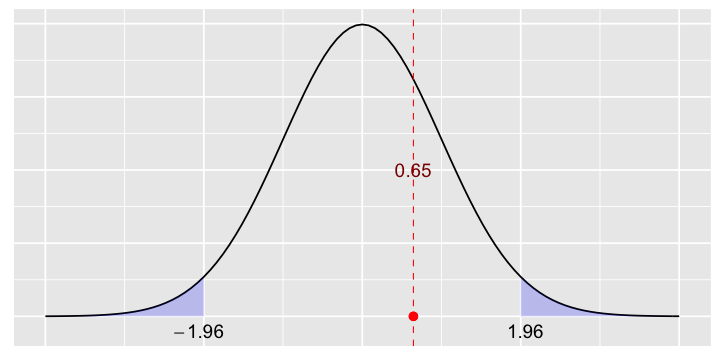

In [126]:
p_hat = 0.6
n = 10

sd_p = sqrt(p_hat*(1-p_hat)/n)

z_stat = (p_hat - 0.5)/sd_p   # считаем наблюдаемую статистику
z_stat_picture(z_stat, alpha = 0.05, alternative = 'two-sided')

Для нашей сиуации гипотеза о том, что Бонд не различает между собой напитки, не отвергается. Можно выбрать одностороннюю альтернативу

$$
H_1: \quad p > \frac{1}{2}.
$$

В таком случае против нулевой гипотезы будут свидетельствовать только большие значения статистики и мы все $\alpha\%$ критиической области должны перекинуть направо. Гипотеза о рандомности выбора Бонда снова не отвергается. 

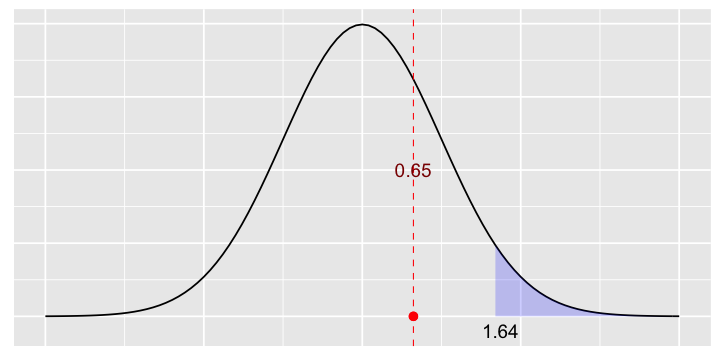

In [127]:
z_stat_picture(z_stat, alpha = 0.05, alternative = 'greater')

Подведём итоги. Проверка гипотез заключается в понимании того, какая из двух альтернатив наиболее вероятно при имеющихся данных. Она осуществляется с помощью специально подобранных случайных величин, статистик. Статистики подбираются так, чтобы их распределение, при справделивости нулевой гипотезы, было известно. По сути, каждый критерий для проверки гипотезы это полноценная теорема со своими предпосылками, которые могут нарушаться.   Алгоритм проверки гипотез выглядит следующим образом: 

1. Задаём уровень значимости $\alpha$ (сколько парашютистов погибнут).
2. Формулируем нулевую и альтернативную гипотезы.
3. Выбираем статистику для проверки гипотезы.
4. Находим наблюдаемое значение статистики по выборке.
5. Находим критические точки для выбранной статистики. Именно для этого нам нужно знать её распределение. 
6. Сравниваем наблюдаемое значение с критическими. Если оно попало в критическую область, отвергаем нулевую гипотезу. Если нет, то не отвергаем.

# 2. Ошибки, которые мы можем совершить

Проверяя гипотезы, мы можем совершать ошибки. Выделяют две ошибки: первого рода и второго рода. Мы можем либо ошибочно отвергнуть верную гипотезу, либо ошибочно не отвергнуть неверную гипотезу.


|                     | $H_0$ верна    | $H_0$ не верна |
|---------------------|----------------|----------------|
|$H_0$ не отвергается |   ok           |Ошибка $II$ рода|
|$H_0$ отвергается    |Ошибка $I$ рода |  ok            |

Вероятность ошибки первого рода, $P(H_0 \text{ отвергнута} \mid H_0 \text{ верна})$, называют __уровнем значимости__ и обозначают как $\alpha$. 

Ошибки первого рода в механизме проверки гипотез являются более критичными. Перед исследованием мы фиксируем уровень значимости на каком-то уровне. Ошибка второго рода минимизируется по остаточному принципу. Её вероятность, $P(H_0 \text{ не отвергнута} \mid H_0 \text{ не верна})$, обозначают как $\beta$. Величину $1-\beta$ называют __мощностью критерия.__  Критерий с наибольшей мощностью - классный. 

Неравнозначность нулевой и альтернативной гипотез можно проиллюстрировать на примере презумпции невиновности. Подсудимый всегда по умолчнию невиновен (это нулевая гипотеза), и, если доказателств обратному нет, нельзя утверждать, что он преступник, даже если он на самом деле совершил преступление. 

Про ошибки и мощность мы более подробно поговорим в следующий раз.


![ ](https://pp.userapi.com/c840128/v840128140/6daec/ezr1fAgrFKg.jpg) 

# 3. P-value 

Ещё одно важное определение. __P-значение__ или __достигаемый уровень значимости__ облегчают проверку гипотез и выводятся почти во всех протоколах. В дальнейшем вы регулярно будете сталкиваться с этим понятием. 

Сначала про то как это выглядит на пальцах. Выше мы с вами для двусторонней альтернативы построили красивую картинку. Давайте немного дополним её. Как обычно, код для рисования картинок можно не понимать. 

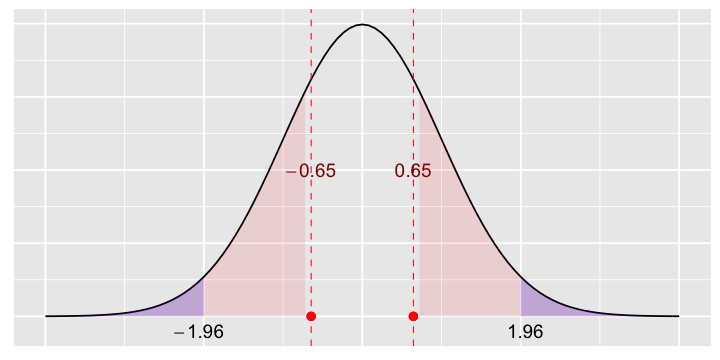

In [128]:
dlimit_left  <- limitRange(dnorm, -Inf, -z_stat)
dlimit_right <- limitRange(dnorm, z_stat, Inf)

z_stat_picture(z_stat, alpha = 0.05, alternative = 'two-sided') + 
    # Делаем красную заливку
    stat_function(fun=dlimit_left, geom="area",  fill="red", alpha=0.1) +
    stat_function(fun=dlimit_right, geom="area", fill="red", alpha=0.1) +
    # Добавляем симметричкую пунктирную линию 
    geom_point(aes(x=-z_stat,y=0), color="red", size=2) +
    geom_vline(xintercept = -z_stat, size=0.3, linetype="dashed", color="red") +
    annotate("text", label=round(-z_stat,2), x= -z_stat, y=0.2, parse=T, size=4, color="darkred")


Цифры $1.96$ и $-1.96$ это критические значения статистики. Голубая площадь за ними в сумме даёт уровень значимости $\alpha$. Красные точки это наблюдаемое значение статистики $0.65$ и симметричное ему значение $-0.65$. Красная плошадь это и есть P-значение. 

Если красная площадь получилась больше синей, это означает, что наблюдаемое значение статистики попало между критическими и гипотеза не отвергается. Если красная площадь оказалась меньше синей, то это означает, что наблюдаемое значение ударило в один из хвостов и гипотеза отвергается. Посчитаем для данной ситуации p-значение.

In [129]:
2*pnorm(-z_stat)  # Нашли площадь левого красного хвоста и умножили на два

[1] 0.518605

Получается, что красная площадь равна $0.52$. Это гораздо больше, чем $\alpha = 0.05$. Значит гипотеза не отвергается. Чем ниже получилось p-значение, тем сильнее данные свидетельствуют против нулевой гипотезы в пользу альтернативы.

Вопрос: а какой уровень значимости надо выбрать, чтобы гипотеза впервые отверглась? Ответ: равный p-значению. 

Пощупали на пальцах, теперь давайте дадим чёткое определение. __Достигаемый уровень значимости__ или __P-значение__ - это вероятность при справедливости нулевой гипотезы получить такое же значение статистики, как в эксперименте или ещё более экстремальное. 

$$p = P(z \ge z_{\text{набл.}} \mid H_0)$$

В нашем случае $p = 0.518$. То есть вероятность получить наши или ещё более экстримальные данные при условии справедливости нулевой гипотезы довольно высока. Это говорит в пользу нулевой гипотезы. Если бы вдруг получилось, что $p = 0.002$, то вероятность получить наши или ещё более экстримальные данные при верности нулевой гипотезы была бы очень маленькой и это говорило бы против нулевой гипотезы. Тем не менее, редкие события тоже происходят.

# 4. Параметрические критерии   

Выше мы сформулировали свою первую гипотезу и проверили её. Попутно мы разобрались со всякими мелочами вроде уровня значимости, $p$-значений и тп. Сейчас мы займёмся проверкой разных гипотез. Каждый критерий будем формулировать как небольшую теоремку. Сразу же будем проверять на критерий какую-нибудь гипотезу. 

Те критерии, которые мы будем использовать в этой тетрадке называются __параметрическими,__ потому что в проверяемых ими гипотезах высказывается предположение о значении параметра распределений, из которых предположительно взята выборка. 


# 5.1 Z-критерий для доли 

Выборка: 

$$X_1, \ldots, X_n \sim iid \hspace{1mm} Ber(p)$$

Нулевая и альтернативная гипотезы: 

$$
\begin{aligned}
&H_0: \hspace{2mm} p = p_0 \\
&H_1: \hspace{2mm} p < \ne > p_0
\end{aligned}
$$

Асимптотическое распределение оценки $\hat p = \bar x$ при верности нулевой гипотезы:  

$$
\hat p \sim N\left(p_0, \frac{p_0(1-p_0)}{n}  \right)
$$

Статистика для проверки гипотезы: 

$$
Z = \frac{\hat p - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}} \sim N(0,1)
$$

### Проблема: 

В 70-х годах известный педиатр и автор книг по воспитанию детей Бенджамин Спок был арестован за участие в антивоенной демонстрации в Бостоне. Его дело должен был рассматривать суд присяжных. Отбор присяжных — это сложная многоступенчатая процедура. На очередном этапе остаётся 300 человек, из которых отбираются финальные 12. В процессе Бенджамина Спока среди этих 300 только 90 были женщинами, и адвокаты подали протест. Поскольку в те времена воспитанием детей занимались в основном женщины, Бенджамин Спок среди них был более популярен, поэтому адвокаты заподозрили, что обвинение специально пытается сделать финальный состав присяжных менее благосклонным к подсудимому.

In [130]:
# Что делать? 

Нулевая гипотеза состоит в том, что процедура отбора беспристрастна, женщины попадают в присяжные с вероятностью $0.5$. Подозрение состоит в том, что для женщин эта вероятность занижена. Из-за этого будем рассматривать в качестве альтернативной гипотезы - одностороннюю. 

p-value: 2.131096e-12

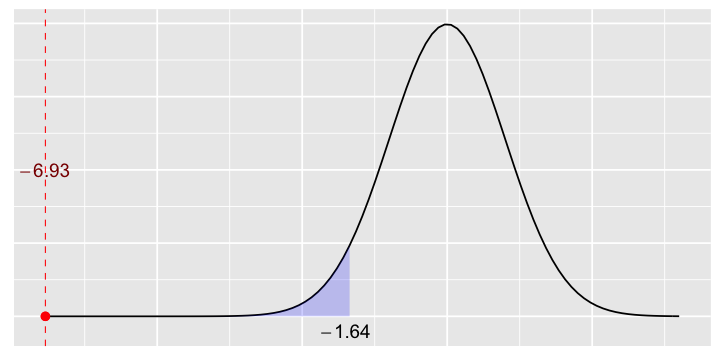

In [131]:
n = 300
p_hat = 90/300

# Вручную
z_stat = (p_hat - 0.5)/sqrt(0.5*(1-0.5)/n)
z_stat_picture(z_stat, alpha = 0.05, alternative = 'less')
p_value = pnorm(z_stat)
cat('p-value:',p_value)

Видим, что наблюдаемое значение статистики оказалось глубоко в критической области. Гипотеза о беспрестрастности отбора отвергается. Значание $pvalue$ оказалось меньше $0.05$. 

Можно попробовать использовать двустороннюю альтернативу. Это будет означать, что вероятность отбора женщин может быть как занижена, так и завышена.

p-value: 4.262192e-12

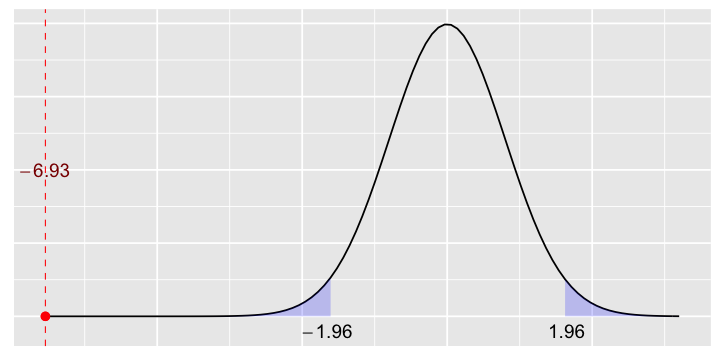

In [132]:
n = 300
p_hat = 90/300

# Вручную
z_stat = (p_hat - 0.5)/sqrt(0.5*(1-0.5)/n)
z_stat_picture(z_stat, alpha = 0.05, alternative = 'two-sided')
p_value = 2*pnorm(z_stat)
cat('p-value:',p_value)

Наши выводы это никак не поменяет. Сделаем то же самое во встроенном в R пакете. Это позволяеь сделать команда [`prop.test`.](http://stat.ethz.ch/R-manual/R-devel/library/stats/html/prop.test.html)

In [133]:
test_res = prop.test(90, 300, p = 0.5, alternative = "less",
                     conf.level = 0.95, correct = FALSE)
test_res


	1-sample proportions test without continuity correction

data:  90 out of 300, null probability 0.5
X-squared = 48, df = 1, p-value = 2.131e-12
alternative hypothesis: true p is less than 0.5
95 percent confidence interval:
 0.0000000 0.3451483
sample estimates:
  p 
0.3 


На выходе получаем табличку с основными результатами проверки гипотезы. В том числ оценку параметра и доверительный интервал для него. Через знак доллара можно вытянуть отдельные части протокола. 

In [134]:
test_res$p.value
test_res$estimate

[1] 2.131096e-12

p 
0.3

# 5.2  Z-критерий для доли для двух независимых выборок

В случае двух выборок будем поступать ровно также, как при строительстве доверительных интервалов. Попробуйте проделать всё, что написано ниже самостоятельно руками.

Выборки: 

$$
\begin{aligned}
& X_1, \ldots, X_{n_1} \sim iid \hspace{1mm} Ber(p) \\
& Y_1, \ldots, Y_{n_2} \sim iid \hspace{1mm} Ber(p)
\end{aligned}
$$

Нулевая и альтернативная гипотезы: 

$$
\begin{aligned}
&H_0: \hspace{2mm} p_1 = p_2 \\
&H_1: \hspace{2mm} p_1 < \ne > p_2
\end{aligned}
$$

Асимптотическое распределения оценок $\hat p_1 = \bar x$ и $\hat p_2 = \bar y$ при верности нулевой гипотезы:  

$$
\hat p_1 \sim N\left(p, \frac{p(1-p)}{n_1} \right)
$$

$$
\hat p_2 \sim N\left(p,\frac{p(1-p)}{n_2} \right)
$$


Значит статистика $\hat p_1 - \hat p_2$ тоже будет иметь нормальное распределение. Найдём её параметры: 

$$
\begin{aligned}
& E(\hat p_1 - \hat p_2) = p - p = 0
& Var(\hat p_1 - \hat p_2) = p(1-p)\frac{n_1 + n_2}{n_1 \cdot n_2}
\end{aligned}
$$


Статистика для проверки гипотезы: 

$$
Z = \frac{\hat p_1 - \hat p_2}{\sqrt{P(1-P)\frac{n_1 + n_2}{n_1 n_2}}} \sim N(0,1),
$$

где $P = \frac{m_1 + m_2}{n_1 + n_2} = \frac{\hat p_1 n_1 + \hat p_2 n_2}{n_1 + n_2}$


### Проблема: 

1600 гражданам Великобритании с правом голоса задают вопрос: одобряют ли они деятельность премьер-министра. 944 человека говорят, что одобряют. Через 6 месяцев опрос повторяется. На этот раз из 1600 опрошенных 880 говорят, что поддерживают премьер-министра. Нужно понять изменился ли рейтинг премьер-министра. 


Чтобы понять, изменился ли рейтинг премьер-министра, нужно использовать статистический критерий. В качестве альтернативной гипотезы уместно взять двустороннюю, так как рейтинг мог как упасть, так и вырасти. Сначала проделаем всё вручную. 

p-value: 0.02229829

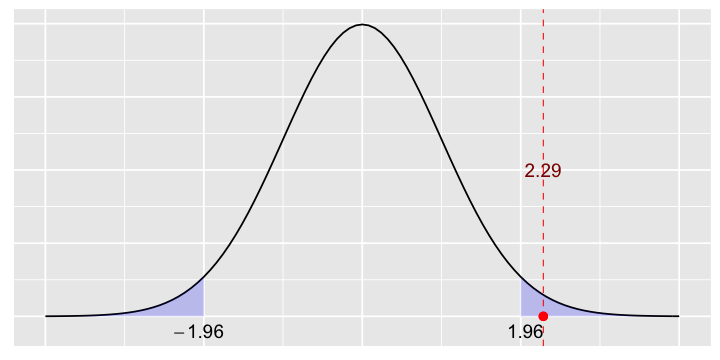

In [135]:
n1 = 1600 
m1 = 944

n2 = 1600
m2 = 880

p1_hat = m1/n1
p2_hat = m2/n2
P = (m1 + m2)/(n1 + n2)

z_stat = (p1_hat - p2_hat)/(sqrt(P*(1-P)*(n1+n2)/(n1*n2)))

z_stat_picture(z_stat, alpha = 0.05, alternative = 'two-sided')
p_value = 2*pnorm(-z_stat)
cat('p-value:',p_value)

P-value меньше $0.05$.  На уровне значимости $5\%$ гипотезе о том, что рейтинг премьера не изменился, отвергается. По-другому мы можем понять то же самое, увидем, что наблюдаемое значение статистики попадает в критическую область. Проверим гипотезу внутренними средствами R и получим тот же результат. 

In [136]:
test_res = prop.test(x = c(m1, m2), n = c(n1, n2), correct = FALSE)
test_res


	2-sample test for equality of proportions without continuity
	correction

data:  c(m1, m2) out of c(n1, n2)
X-squared = 5.2224, df = 1, p-value = 0.0223
alternative hypothesis: two.sided
95 percent confidence interval:
 0.005721636 0.074278364
sample estimates:
prop 1 prop 2 
  0.59   0.55 


# 5.3  Z-критерий для доли для двух связанных выборок 

На самом деле в задаче выше в обоих опросах участвовали одни и те же люди. То есть выборки связаны между собой, так как измерения проводились на одних и тех же объектах. На практике довольно часто встречается такая ситуация, поэтому давайте рассмотрим как модернизировать критерий под неё. 

Мы можем перенести собранные по выборке данные в небольшую табличку

|  | + | - | $\Sigma$ | 
|--|---|---|----------|
|+ |794|150|944       |
|- |86 |570|656       |
|$\Sigma$|880|720|1600|

По столбцам отложим второй опрос, по строчкам первый. Из таблички можно понять, что $794$ человека поддержали премьера в обоих опросах, $150$ только в первом и т.д. 

|  | + | - | $\Sigma$ | 
|--|---|---|----------|
|+ |e|f|e+f       |
|- |g|h|g+h       |
|$\Sigma$|e+g|f+h|n|


Если мы будем расчитывать итоговую статистику как 

$$
Z = \frac{f - g}{\sqrt{f + g - \frac{(f-g)^2}{n}}} \sim N(0,1),
$$

то мы внутри неэ учтём только недиагональные элементы. То есть только те объекты, на которых значение в выборке различаются. Грубо говоря, это позволит нам подчистить нашу выборку от взаимосвязей.

# 6.1 Гипотезы о среднем для нормального распределения

Позволяет проверять гипотезы о математических ожиданиях нормального распределения.

Выборка: 

$$X_1, \ldots, X_n \sim iid \hspace{1mm} N(\mu, \sigma^2)$$

Нулевая и альтернативная гипотезы: 

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu = \mu_0 \\
&H_1: \hspace{2mm} \mu < \ne > \mu_0
\end{aligned}
$$

Распределение оценки $\hat \mu = \bar x$ при верности нулевой гипотезы:  

$$
\hat \mu \sim N\left(\mu_0, \frac{\sigma^2}{n}  \right)
$$

Обратите внимание, что из-за нормальности распределения это распределение является __точным,__ а не асимптотическим. Это очень важная деталь. 

Статистика для проверки гипотезы: 

$$
Z = \frac{\hat \mu - \mu_0}{\frac{\sigma}{\sqrt{n}}} \sim N(0,1)
$$

Обратите внимание на дисперсию. Про неё в нулевой гипотезе не делается никаких предположений. Она уже заранее должна быть для нас известна. Если это так, то с распределением всё хорошо и можно проверять гипотезу.

Что делать, если дисперсия неизвестна? Оценить её по выборке! Тогда у нас будет уже целых два распределения: для среднего и для выборочной дисперсии. Со средним всё просто: 

$$
\hat \mu \sim N\left(\mu_0, \frac{\sigma^2}{n}  \right)
$$

С дисперсией чуток сложнее. По Тореме Фишера, если генеральная совокупность имеет нормальное распределение, то статистика 

$$\frac{n s^2}{\sigma^2} \sim \chi^2_{n-1}.$$ 

Не помните такого факта? Марш в лекции! Найдите его и внимательно изучите!

Владея этим фактом, мы можем сделать для статистики для проверки гипотезы небольшой финт, который позволит заменить неизвестное $\sigma$ на найденное по выборке $s$ и понять как будет распределена итоговая дробь: 

$$
\frac{\hat \mu - \mu_0}{\frac{s}{\sqrt{n}}} = \frac{\hat \mu - \mu_0}{\frac{\sigma}{\sqrt{n}}} : \sqrt{\frac{1}{n-1} \frac{(n-1) s^2}{\sigma^2}} \sim \frac{N(0,1)}{\sqrt{\frac{\chi^2_{n-1}}{n-1}}} = t_{n-1} 
$$

Подытожим. Если дисперсия неизвестна и её надо оценить, то статистика для проверки гипотезы будет иметь распределение Стьюдента: 

Статистика для проверки гипотезы: 

$$
t = \frac{\hat \mu - \mu_0}{\frac{s}{\sqrt{n}}} \sim t(n-1)
$$

Обратите внимание, что это распределение точное. Также обратите внимание, что при $n \to \infty$ распределение Стьюдента сходится к нормальному. Значит наша статистика будет иметь асимптотически нормальное распределение и при больших $n$ можно смело использовать его для проверки гипотез. Погрешность при его использовании будет небольшой. Но ежели нужен точный результат, а не асимптотический, используйте распределение Стьюдента. 

### Проблема: 

Средний вес детей при рождении. Средний вес детей при рождении составляет 3300 г. В то же время, если мать ребёнка живёт за чертой бедности, то средний вес таких детей — 2800 г. Вес при рождении — это очень важный показатель здоровья ребенка. Так, только 7% детей рождаются с весом меньше 2.5 кг, однако на них приходится 70% детских смертей.
С целью увеличить вес тех детей, чьи матери живут за чертой бедности, разработана экспериментальная программа ведения беременности. Чтобы проверить ее эффективность, проводится эксперимент. В нем принимают участие 25 женщин, живущих за чертой бедности. У всех них рождаются дети, и их средний вес составляет 3075 г. Выборочное стандартное отклонение составило $500$ г.

Сформулируем эту задчу с математической точки зрения! В качестве нулевой гипотезы будем рассматривать то, что программа неэффективна. То есть средний вес у детей, прошедших программу точно такой же, как и у детей, живущих за чертой бедности. Проверять гипотезу будем против двусторонней альтернативы, состоящей в том, что программа оказывает какое-то влияние на вес детей. 

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu = 2800 \\
&H_1: \hspace{2mm} \mu \ne 2800
\end{aligned}
$$

Теоретическая дисперсия неизвестна. Её придётся оценивать. Из-за этого будем использовать $t-$статистику. Данные можно найти в [табличке.]( )

Warning message:
“Computation failed in `stat_function()`:
неиспользованный аргумент (df = 25)”

p-value: 0.005573915

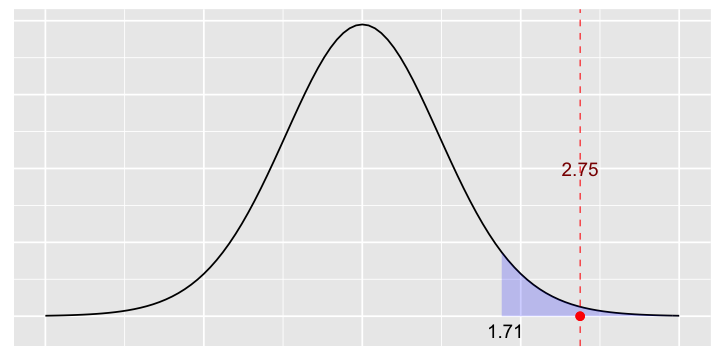

In [137]:
mu_0 = 2800

mu_hat = 3075
s = 500
n = 25

t_stat = sqrt(n)*(mu_hat - mu_0)/s

# обратите внимание, что p-value теперь мы считаем по 
# распределению стьюдента! Картинку тоже строим для него 
t_stat_picture(t_stat, n, alpha = 0.05, alternative = 'greater')

p_value = pt(-t_stat, df=n-1)
cat('p-value:',p_value)

Выводы!!!


Проверим то же самое внутренними средствами R. Это помогает сделать команда [`t.test`.](http://stat.ethz.ch/R-manual/R-devel/library/stats/html/t.test.html)

In [80]:
t.test(3075, alternative = 'greater', mu = 2800, 
       conf.level = 0.95 )

ERROR: Error in t.test.default(3075, alternative = "greater", mu = 2800, conf.level = 0.95): not enough 'x' observations


Обратите внимание, при проверки гипотезы, мы неявно пользовались предположением, что вес детей распределён нормально. На практике это часто не так. В следующий раз мы научимся проверять гипотезу о нормальности выборки и ещё раз обсудим зачем она нужна. 

# 6.2 Гипотезы о среднем в общем случае 

Если выборка не распределена нормально, то наша оценка для среднего будет иметь __асимптотически нормальное__ распределение:

$$
\hat \mu \sim N\left(\mu_0, \frac{\sigma^2}{n}  \right)
$$

В такой ситуации мы не можем легко нащупать точное распределение для статистики. Поэтому для проверки гипотезы мы будем использовать асимптотическое распределение статистики:

$$
z = \frac{\hat \mu - \mu_0}{\frac{\hat \sigma}{\sqrt{n}}} \sim N(0,1)
$$


In [ ]:
# Задачку про шахты и распределение пуассона
# Либо задача про свету

__Ещё раз, ещё раз!__ Критерий для среднего является точным только в случае нормального распределения! Обычно в матстате и метрике ищут нормальное распределение только для того, чтобы пользоваться точными распределениями. Больше ни для чего это не надо. Запомните это!

# 6.3 Двухвыборочный критерий стьюдента для независимых выборок 

Двухвыборочные критерии Стьюдента позволяют сравнивать средние значение двух выборок из нормальных распределений. Вывести  статистику и её разспеределение можно по аналогии с тем, как мы делали это в доверительных интервалах. 

Выборки: 

$$
\begin{aligned}
& X_1, \ldots, X_{n_1} \sim iid \hspace{1mm} N(\mu_1, \sigma_1^2) \\
& Y_1, \ldots, Y_{n_2} \sim iid \hspace{1mm} N(\mu_2, \sigma_2^2)
\end{aligned}
$$

Нулевая и альтернативная гипотезы: 

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_1 = \mu_2 \\
&H_1: \hspace{2mm} \mu_1 < \ne > \mu_2
\end{aligned}
$$

Асимптотическое распределения оценок $\hat \mu_1 = \bar x$ и $\hat \mu_2 = \bar y$ при верности нулевой гипотезы:  

$$
\hat \mu_1 \sim N\left(\mu, \frac{\sigma_1}{n_1} \right)
$$

$$
\hat \mu_2 \sim N\left(\mu,\frac{\sigma_2}{n_2} \right)
$$

Значит статистика $\hat \mu_1 - \hat \mu_2$ тоже будет иметь нормальное распределение. Найдём её параметры:

$$
\begin{aligned}
& E(\hat \mu_1 - \hat \mu_2) = \mu - \mu = 0
& Var(\hat \mu_1 - \hat \mu_2) = \frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}
\end{aligned}
$$

Статистика для проверки гипотезы: 

$$
Z = \frac{\hat \mu_1 - \hat \mu_2}{\sqrt{ \frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}} }
$$

И вот тут начинаются проблемы. 

* Если дисперсии известны, то $Z \sim N(0,1)$.  Это распределение точное, если две изначальные выборки нормально распределены. Конечно же, так бывает довольно редко. 
* Если диспресии неизвестны, но равны, мы можем скзать, что 

$$ t = \frac{\hat \mu_1 - \hat \mu_2}{\sqrt{ \frac{s^2}{n_1} + \frac{s^2}{n_2}}} \sim t(n_1 + n_2 -2)
$$ 

Диспресия расчитывается как 

$$
s^2 = \frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1 + n_2 -2}.
$$


* В более сложных ситуациях, когда диспресии неизвестные и разные, возникает проблема. Если заменить неизвестные дисперсии на выборочные, получим $t$-статистику, которая при выполнении нулевой гипотезы будет распределена по Стьюденту

$$
t = \frac{\hat \mu_1 - \hat \mu_2}{\sqrt{ \frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}} } \sim t(\nu).
$$

Но есть две проблемы. Во-первых, число степеней свободы $\nu$ у этого распределения будет считатся по довольно сложной формуле: 

$$
\nu = \frac{ \left(\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2} \right)^2 }{ \frac{s_1^4}{n_1^2(n_1 -1)} + \frac{s_2^4}{n_2^2(n_2-1)}}
$$

Во-вторых, нулевое распределение будет не точным, а приближённым. Точного решения (то есть точного нулевого распределения для такой статистики) не существует. Это проблема называется [проблемой Беренца-Фишера.](https://ru.wikipedia.org/wiki/Нерешённые_проблемы_статистики) Она говорит, что невозможно точно сравнить две средние величины для выборок, дисперсии которых неизвестны. 

Апроксимация, которую мы посмотрели выше, будет достаточно точной в двух ситуациях: когда выборки одинаокового объёма. Либо если знак между $n_1$ и $n_2$ такой же , как между $\sigma_1$ и $\sigma_2$. То есть, если из выборки с большей дисперсией собрано больше наблюдений. 

У вас в лекциях были первые две ситуации. Третью ситуацию вы не обсуждали, но я счёл, что вы должны о ней услышать. 

In [86]:
df = read.csv('/Users/fulyankin/Yandex.Disk.localized/R/R_prob_data/weight.txt', sep='\t') 
length(df$Before)

[1] 29

# 6.4 Двухвыборочный критерий стьюдента для связанных выборок 

Если выборки связаны между собой, то ситуация очень сильно упрощается. Фактически это означает, что у нас был какой-то объект. Мы пронаблюдали по нему выборку $X_1, \ldots, X_n$. Потом мы что-то сделали с этим объектом и после пронаблюдаль выбоку $Y_1, \ldots, Y_n$. После мы решили проверить гипотезу о том, что наше воздействие имело силу. 

В данном случае разность $\bar y - \bar x$ это то же самое, что $\overline{x-y}$. Таким образом, $t$-критерий для двух связных выборок эквивалентен одновыборочному $t$-критерий, примененному к выборке попарных разностей. 

$$ d_i = X_i - Y_i $$

$$ s^2 = \frac{1}{n-1}\sum_{i=1}^n (d_i - \bar d )^2$$

$$ t = \frac{\bar{d}}{s/\sqrt{n}} \sim t(n-1)$$

Из-за того, что мы наблюдаем одни и те же объекты, никаких проблем с дисперсией не возникает.

# 6.5 Гипотеза о равенстве средних для других распределений

Для проверки гипотезы о равенстве средних для произвольных распределений используют асимптотический тест. Статистика 

$$
Z = \frac{\hat \mu_1 - \hat \mu_2}{\sqrt{ \frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}} }
$$

имеет асимптотически нормальное распределенеи и используется для проверки гипотез для произвольных распределений. 

In [ ]:
# Какая-нибудь гипотеза 

# 7.1 Гипотезы о дисперсии для нормального распределения 

Обычно рисёрчеры проверяют гипотезы о трёх вещах: о долях, средних и дисперсиях. Мы с вами поговорили о критериях, используемых для долей и средних. Без обсуждения осталась только дисперсия. Пусть снова выборка у нас из нормального распределения:

$$X_1, \ldots, X_n \sim iid \hspace{1mm} N(\mu, \sigma^2)$$

Нулевая и альтернативная гипотезы выглядят следующим образом: 

$$
\begin{aligned}
&H_0: \hspace{2mm} \sigma^2 = \sigma^2_0 \\
&H_1: \hspace{2mm} \sigma^2 < \ne > \sigma^2_0
\end{aligned}
$$

Говоря другими словами, мы хотим понять насколько сильно дисперсия отличается от $\sigma_0^2$. Для того, чтобы измерить расстояние от полученной по выборке дисперсии до дисперсии, предположенной в нулевой гипотезе, нужна статистика. Обычно пытаются посмотреть на то, что происходит с отношением дисперсий 

$$\frac{s^2}{\sigma_0^2}.$$ 

Если отношение оказалось близким к единице, то супер! Дисперсии очень похожи и гипотеза не отвергается. Если отношение слишком маленькое или слишком большое, то плохо. Несостыкуется. Как обычно, осталось придумать статистику, которая помогла бы нам понимать когда расстояние получилось слишком большим, а когда слишком маленьким. 

Я думаю, что статистика уже пришла к вам на ум. Если математическое ожидание известно, то 

$$\frac{n s^2}{\sigma^2} =\sum_{i=1}^n \left(\frac{X_i - \mu}{\sigma}\right)^2 \sim \chi^2_n.$$

Если математическое ожидание неизестно, то используем теорему Фишера и понимаем, что 

$$\frac{(n-1) s^2}{\sigma^2} =\sum_{i=1}^n \left(\frac{X_i - \bar x}{\sigma}\right)^2 \sim \chi^2_{n-1}.$$



Как вы помните из тетрадки про доверительные интервалы, одна степень свободы сгорает из-за того, что мы вынуждены оценивать сразу два параметра: среднее и дисперсию. Это накладывает на нашу выборку одно линейное ограничение и количество случайных величин, доступных для варьирования, уменьшается на одну. Обратите внимание, что из-за нормальности распределения эта статистика является __точной,__ а не асимптотической. Это очень важная деталь. 

# 7.2 Гипотезы о равенстве дисперсий 

Выборки: 

$$
\begin{aligned}
& X_1, \ldots, X_{n_1} \sim iid \hspace{1mm} N(\mu_1, \sigma_1^2) \\
& Y_1, \ldots, Y_{n_2} \sim iid \hspace{1mm} N(\mu_2, \sigma_2^2)
\end{aligned}
$$

Нулевая и альтернативная гипотезы: 

$$
\begin{aligned}
&H_0: \hspace{2mm} \sigma^2_1 = \sigma^2_2 \\
&H_1: \hspace{2mm} \sigma^2_1 < \ne > \sigma^2_2
\end{aligned}
$$

По аналогии с предыдущим пунктом, будем смотреть на то, насколько велико расстояние между двумя дисперсиями

$$
\frac{s_1^2}{s_2^2}.
$$

Если эта величина окажется близка к единице, значит дисперсии похожи. Осталось найти статистику, которую можно было бы использовать, чтобы понять насколько выборочные дисперсии оказались близки. При верности нулевой гипотезы, обе выборки обладают одинаковой дисперсией, значит мы можем сделать следущий финт:

$$
F = \frac{(n_1-1) \cdot s_1^2}{\sigma^2 \cdot (n_1-1)} : \frac{(n_2-1) \cdot s_2^2}{\sigma^2 \cdot(n_2-1)}.
$$

При верности нулевой гипотезы, получаем, что 

$$
F \sim \frac{\chi^2_{n_1-1}}{n_1-1} : \frac{\chi^2_{n_2-1}}{n_2-1} = F(n_1-1,n_2-1).
$$

Отношение дисперсий, при верности нулевой гипотезы, имеет распределение Фишера с $n_1-1$ и $n_2-1$ степенями свободы. Именно его мы и будем использовать как статистику для проверки гипотезы. Ещё раз обращаю ваше внимание на то, что такое распределение будет только при нормальности выборок. 


In [ ]:
* добавить на графики с проверкой гипотез оси!

# 8. Значимость и существенность 

На самом деле эксперименты проводятся не для того, чтобы получить значение p-value. Как правило, исследователя интересует размер эффекта, то есть степень отклонения данных от нулевой гипотезы. Например, если эксперимент связан с проверкой способностей предсказателя будущего, то размер эффекта — это вероятность верного предсказания. Если проверяется эффективность лекарства, то размер эффекта — это вероятность выздоровления пациента, который это лекарство принимает, за вычетом эффекта плацебо. При запуске программы лояльности для пользователей интернет-магазина размер эффекта — это последующее увеличение среднего чека.

Размер эффекта — это величина, определенная на генеральной совокупности. Но, как правило, у исследователя есть только небольшая выборка из нее, а оценка размера эффекта по выборке — это случайная величина. Маленький достигаемый уровень значимости является показателем того, что такую оценку размера эффекта, какая получена по выборке, с маленькой вероятностью можно было получить случайно.

Достигаемый уровень значимости зависит не только от размера эффекта, но и от объема выборки, по которой оценивается эффект. Если выборка небольшая, скорее всего, нулевая гипотеза на ней не отвергается (если только она не слишком дикая). Однако с ростом объема выборки начинают проявляться все более тонкие отклонения данных от нулевой гипотезы. Велика вероятность, что на достаточно большой выборке значительная часть разумных нулевых гипотез будет отвергнута. Именно поэтому, даже если нулевая гипотеза отвергнута, это еще не значит, что полученный эффект имеет какую-то практическую значимость, её нужно оценивать отдельно. Чтобы лучше это понять, давайте рассмотрим несколько примеров.

Первый пример связан с [большим исследованием](https://jamanetwork.com/journals/jama/fullarticle/185585), в рамках которого на протяжении трех лет у большой выборки женщин измеряли вес, а также оценивали, насколько активно они занимаются спортом. По итогам исследования выяснилось, что женщины, которые в течение этого времени упражнялись не меньше часа в день, набрали значительно меньше веса, чем женщины, которые упражнялись менее $20$ минут в день. Статистическая значимость этого результата достаточно высока: $p < 0.001$. Проблема в размере эффекта: разница в набранном весе между двумя исследуемыми группами женщин составила всего $150$ граммов. $150$ граммов за $3$ года — это не очень много. Крайне сомнительно, что этот эффект имеет какую-то практическую значимость.

Еще один пример связан с [клиническими испытаниями гормонального препарата «Премарин» (в книге 2 глава, нет я не читал)](https://books.google.ru/books?hl=ru&lr=&id=UUcgAwAAQBAJ&oi=fnd&pg=PR13&dq=Ellis+P.D.+The+Essential+Guide+to+Effect+Sizes:+Statistical+Power,+Meta-Analysis,+and+the+Interpretation+of+Research+Results&ots=-c3hqlbtiK&sig=a7rI0I80owEfqCbgkEsE1F1ZzKY&redir_esc=y#v=onepage&q=Ellis%20P.D.%20The%20Essential%20Guide%20to%20Effect%20Sizes%3A%20Statistical%20Power%2C%20Meta-Analysis%2C%20and%20the%20Interpretation%20of%20Research%20Results&f=false), который облегчает симптомы менопаузы. В $2002$ году эти испытания были прерваны досрочно, поскольку было обна- ружено, что прием препарата ведет к значимому увеличению риска развития рака груди (на $0.08\%$), инсульта (на $0.08\%$) и инфаркта (на $0.07\%$). Этот эффект статистически значим; при этом на первый взгляд кажется, что размеры эффектов ничтожны. Например, если кому-то сказать, что его любимые конфеты повышают риск возникновения инфаркта на $0.07\%$, вряд ли это заставит человека отказаться от этих конфет. Тем не менее, если пересчитать размеры эффектов на всю популяцию людей, которым этот препарат может быть потенциально приписан, результатом будут тысячи дополнительных смертей. Разработчики препарата не могут взять на себя эту ответственность, поэтому такой препарат немедленно запрещают и снимают с рынка. Этот пример показывает, что практическую значимость результата нельзя определить на глаз. В идеале она должна определяться человеком, который поставил задачу и понимает предметную область.

Еще один пример — это [испытание лекарства, которое замедляет ослабление интеллекта](http://journals.sagepub.com/doi/abs/10.1177/0013164496056005002) у людей, страдающих болезнью Альцгеймера. В этом исследовании очень сложно измерить размер эффекта. В течение эксперимента одна часть испытуемых должна принимать лекарство, а другая — плацебо. Только по прошествии нескольких лет можно будет сравнить эти две группы. Поэтому такое исследование длится долгое время и дорого стоит. Если при испытании оказывается, что разница между снижением IQ в контрольной группе, где люди принимали плацебо, и тестовой группе, где люди принимали препарат, составляет 13 пунктов, это различие очень большое, и на практике этот эффект крайне значим. При этом может оказаться, что ста- тистическая значимость не была достигнута, то есть $p > \alpha$, и формально нулевую гипотезу об отсутствии эффекта лекарства нельзя отвергнуть. Если предмет исследования очень важен, то, оказавшись в подобной ситуации, возможно, стоит продолжать исследования: набрать еще выборку, уменьшить дисперсию оценки размера эффекта и убедиться в том, что важное открытие не упущено.

В презу: 

(Lee et al, 2010): за три года женщины, упражнявшиеся не меньше часа в день, набрали значимо меньше веса, чем женщины, упражнявшиеся меньше 20 минут в день (p < 0.001). Разница
в набранном весе составила 150 г. Практическая значимость такого эффекта сомнительна.

(Ellis, 2010, гл. 2): в 2002 году клинические испытания гормонального препарата Премарин, облегчающего симптомы менопаузы, были досрочно прерваны. Было обнаружено, что его приём ведёт
к значимому увеличению риска развития рака груди на 0.08%, риска инсульта на 0.08% и инфаркта на 0.07%. Формально эффект крайне мал, но с учётом численности населения он превращается в тысячи дополнительных смертей.

(Kirk, 1996): если при испытании гипотетического лекарства, позволяющего замедлить прогресс ослабления интеллекта больных Альцгеймером, оказывается, что разница в IQ контрольной и тестовой групп составляет 13 пунктов, возможно, изучение лекарства стоит продолжить, даже если эта разница статистически незначима.